In [1]:
## Model

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
samples = [100,1000,10000,100000]

In [2]:
X, y = make_classification(n_samples=1000, n_features=30, n_informative=3, n_redundant = 0, 
                       n_repeated=0, n_classes=2, shuffle=False, random_state=111, n_clusters_per_class=1)

In [3]:
# (-1)**i

In [4]:
def correlate_cols(data, n_informative, c):
    for i in range(data[:,:n_informative].shape[1]):
        data[:,i+n_informative] =  c  * data[:,i]
    return data

In [5]:
X_final = correlate_cols(X, 3, 0.8)

In [6]:
from sklearn.manifold import TSNE

In [7]:
t = TSNE(perplexity=50)

In [8]:
X_embed = t.fit_transform(X[:,[0,1,2]])

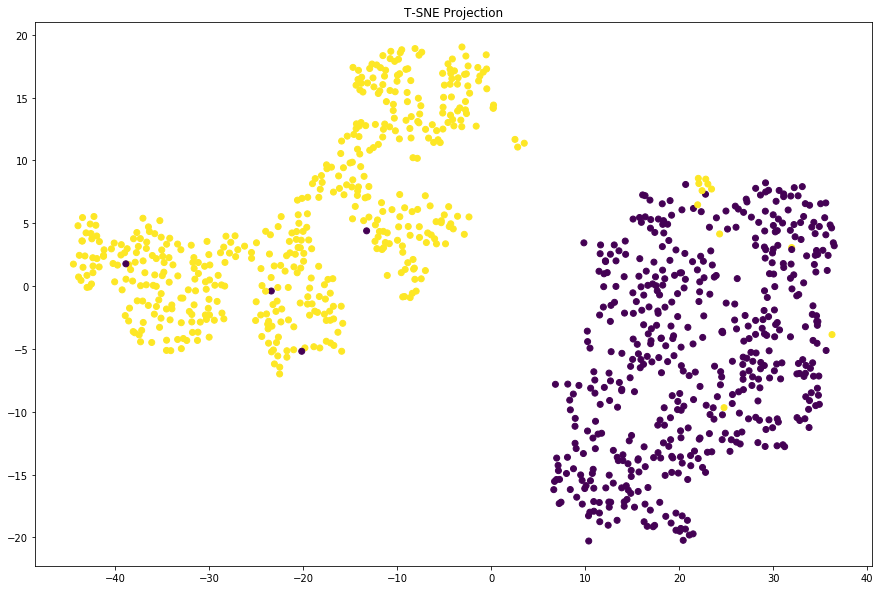

In [9]:
plt.figure(figsize=(15,10))
plt.title('T-SNE Projection')
plt.scatter(X_embed[:,0],X_embed[:,1],c=y)
plt.savefig('linear_boundary.png')

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [13]:
# FILTER

In [14]:
from skfeature.function.similarity_based import fisher_score

In [15]:
idx = fisher_score.fisher_score(X_train, y_train)

In [16]:
def idx_to_class(idx):
    if idx in np.array([0,1,2]):
        return 'informative'
    elif idx in np.array([3,4,5]):
        return 'redundant'
    else:
        return 'random'

In [17]:
pos = np.array([list(idx).index(i) for i in range(3)])

In [18]:
res = np.ones(30)

In [19]:
res[np.array([x for x in idx if x not in pos])] = 0

In [20]:
res

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
selected_features_fisher_train = np.array(X_train)[:, pos]

In [22]:
selected_features_fisher_test = np.array(X_test)[:, pos]

In [23]:
scores = {}

In [28]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV()
clf.fit(X_train[:,[0,1,2]], y_train)
scores.update({'LR':clf.score(X_test[:,[0,1,2]], y_test)})


In [29]:

clf = LogisticRegressionCV()
clf.fit(selected_features_fisher_train, y_train)
scores.update({'LR_Filter':clf.score(selected_features_fisher_test, y_test)})

In [30]:
# WRAPPER

In [31]:
from sklearn.feature_selection import RFE

In [32]:
clf = LogisticRegressionCV()

In [33]:
selector = RFE(clf, 3, step=1)

In [34]:
selector = selector.fit(X_train, y_train)

In [35]:
res2 = np.array([int(i) for i in selector.support_])

In [36]:
res2

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
scores.update({'LR_Wrapper':selector.score(X_test, y_test)})

In [38]:
# EMBEDDED

In [39]:
from sklearn.linear_model import SGDClassifier

In [40]:
el = SGDClassifier(alpha=0.01,loss='log', penalty='elasticnet', max_iter=10000, random_state = 111, l1_ratio=1)

In [41]:
el.fit(X_train, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=1, learning_rate='optimal',
       loss='log', max_iter=10000, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=111, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [42]:
scores.update({'LR_Embedded': el.score(X_test, y_test)})

In [43]:
el.coef_

array([[ 1.15207427, -1.46364057, -1.28701984,  1.15207427, -1.46364057,
        -1.28701984,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [44]:
res3 = np.ones(30)

In [45]:
res3[np.where(el.coef_ == 0)[1]] = 0

In [46]:
res3

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

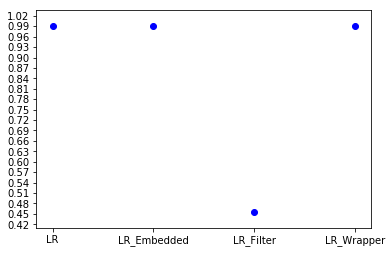

In [61]:
plt.yticks(np.arange(0,1.25,0.03))
plt.scatter(x=scores.keys(), y=scores.values(), c='b')
plt.savefig('accuracy.png')

In [48]:
ind = pd.Series([idx_to_class(i) for i in range(30)])
results = pd.DataFrame(np.column_stack((res,res2,res3)), columns=['Filter','Wrapper','Embedded'])

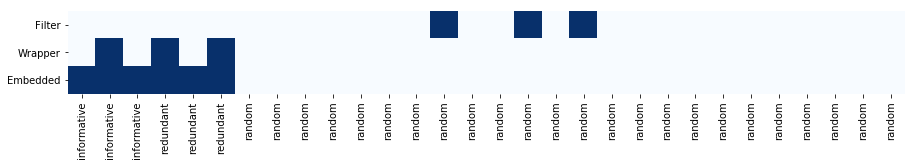

In [49]:
plt.figure(figsize=(15,10))
sns.heatmap(results.T, cbar=False, cmap='Blues', vmin=0, vmax=1, xticklabels=ind, square=True)
plt.savefig('output_high_pos_100000.png')